# Harbour traffic problem
This notebook is developed to address the interference between dredging vessels and container vessels in a certain berth area. Therefore, the berth area is served by both dredging and container vessels.

This is a developed notebook which shows four vessels with different cargo types can serve the same berth while two hopper dredgers also do the maintenance dredging job in the berth location.

Seagoing vessels have separate anchorage areas but the hopper dredgers dump the collected sediments in the same location.

In [1]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime, time
import simpy
import openclsim
import opentnsim

import pandas as pd

import matplotlib.pyplot as plt
import folium

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

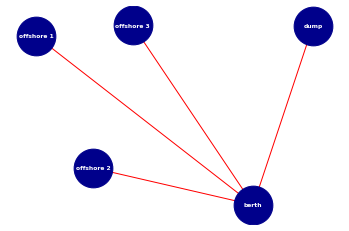

In [3]:
import openclsim.core as core
import shapely.geometry as geom

Location = type('Site',
            (openclsim.core.Identifiable,
             openclsim.core.Log,
             openclsim.core.Locatable,
             openclsim.core.HasContainer,
             openclsim.core.HasResource,), {})

locations = []
location_offshore_01 = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore_01 = {"env": my_env,
                 "name": "offshore 1",
                 "geometry": location_offshore_01,
                 "capacity": 100,
                 "level": 100,
                }
locations.append(Location(**data_offshore_01))
offshore_01 = Location(**data_offshore_01)

location_offshore_02 = shapely.geometry.Point(3.748982, 51.991497)
data_offshore_02 = {"env": my_env,
                 "name": "offshore 2",
                 "geometry": location_offshore_02,
                 "capacity": 100,
                 "level": 100,
                }
locations.append(Location(**data_offshore_02))
offshore_02 = Location(**data_offshore_02)

location_offshore_03 = shapely.geometry.Point(3.826362, 52.116526)
data_offshore_03 = {"env": my_env,
                 "name": "offshore 3",
                 "geometry": location_offshore_03,
                 "capacity": 100,
                 "level": 100,
                }
locations.append(Location(**data_offshore_03))
offshore_03 = Location(**data_offshore_03)

location_berth = shapely.geometry.Point(4.062705498083785,51.95909715255291)
data_berth = {"env": my_env,
              "name": "berth",
              "geometry": location_berth,
              "capacity": 100,
              "level": 100,
             }
# treat berth separately 
# locations.append(Location(**data_berth))
berth = Location(**data_berth)

location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
data_dump = {"env": my_env,
             "name": "dump",
             "geometry": location_dump,
             "capacity": 100,
             "level": 0
            }
locations.append(Location(**data_dump))
dump = Location(**data_dump)   


# Create a network with five nodes and a central node
graph = nx.Graph()

# Add nodes to the network
locations = [berth] + locations
for location in locations:
    graph.add_node(location.name, geometry=location.geometry)
    

# Add edges between the central node and all other nodes
for location in locations[1:]:
    graph.add_edge(berth.name, location.name)

# Draw the network
pos = {location.name: (location.geometry.x, location.geometry.y) for location in locations}
nx.draw_networkx_nodes(graph, pos, node_color='darkblue', node_size=1500)
nx.draw_networkx_edges(graph, pos, edge_color='red', alpha=1, arrowsize=40)
nx.draw_networkx_labels(graph, pos, font_size=6, font_weight='bold', font_color="white")

plt.axis('off')
plt.show()



In [4]:
# add a graph to the environment
my_env.graph = graph

In [5]:
m = folium.Map(location=[52.66, 4.43], zoom_start=8)

folium.Marker(
    [location_dump.y, location_dump.x ], 
    popup="<b>Dump</b>", 
    tooltip="Dump"
).add_to(m)
folium.Marker(
    [location_offshore_01.y, location_offshore_01.x ], 
    popup="<b>Offshore 1</b>", 
    tooltip="Offshore 1"
).add_to(m)
folium.Marker(
    [location_offshore_02.y, location_offshore_02.x ], 
    popup="<b>Offshore 2</b>", 
    tooltip="Offshore 2"
).add_to(m)
folium.Marker(
    [location_offshore_03.y, location_offshore_03.x ], 
    popup="<b>Offshore 3</b>", 
    tooltip="Offshore 3"
).add_to(m)
folium.Marker(
    [location_berth.y, location_berth.x ], 
    popup="<b>Berth</b>", 
    tooltip="Berth"
).add_to(m)

m

In [6]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource  object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        opentnsim.core.Movable,
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.HasResource,
        openclsim.core.HasContainer,
        openclsim.core.Processor,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata
    ),
    {},
)

In [7]:
# data from_site
data_from_site = {
    "env": my_env,
    "name": "berth",
    "geometry": location_berth,
    "capacity": 100,
    "level": 100
}
# instantiate from_site 
from_site = Site(**data_from_site)

# data to_site
data_to_site = {
    "env": my_env,
    "name": "dump",
    "geometry": location_dump,
    "capacity": 100,
    "level": 0
}
# instantiate to_site 
to_site = Site(**data_to_site)

In [8]:
# prepare input data for vessel_01
data_vessel01 = {
    "env": my_env,
    "name": "dredging vessel",
    "geometry": location_berth, 
    "loading_rate": 1,
    "unloading_rate": 5,
    "capacity": 10,
    "v": 10,
    "route": nx.dijkstra_path(my_env.graph, 'berth', 'dump')
}
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)
# assert not vessel01.metadata

In [9]:
# define a path into and out of the habour
path1 = nx.dijkstra_path(my_env.graph, 'offshore 1', 'berth')
path2 = nx.dijkstra_path(my_env.graph, 'berth', 'offshore 1')
path3 = nx.dijkstra_path(my_env.graph, 'offshore 2', 'berth')
path4 = nx.dijkstra_path(my_env.graph, 'berth', 'offshore 2')
path5 = nx.dijkstra_path(my_env.graph, 'offshore 3', 'berth')
path6 = nx.dijkstra_path(my_env.graph, 'berth', 'offshore 3')

path7 = path1+path2[1:]
path8 = path3+path4[1:]
path9 = path5+path6[1:]
display(path7)
display(path8)
display(path9)
    
# create a dict with all important settings
data_vessel02 = {
    "env": my_env,
    "name": 'seagoing vessel 1',
    "geometry": location_offshore_01,
    "route": path1+path2[1:],
    "capacity": 1000,
    "loading_rate": 1,
    "unloading_rate": 1,
    "v": 1
}

data_vessel03 = {
    "env": my_env,
    "name": 'seagoing vessel 2',
    "geometry": location_offshore_02,
    "route": path3+path4[1:],
    "capacity": 1500,
    "loading_rate": 1,
    "unloading_rate": 1,
    "v": 1
}

data_vessel04 = {
    "env": my_env,
    "name": 'seagoing vessel 3',
    "geometry": location_offshore_03,
    "route": path5+path6[1:],
    "capacity": 2000,
    "loading_rate": 1,
    "unloading_rate": 1,
    "v": 1
}


# instantiate vessel_02 
vessel02 = TransportProcessingResource(**data_vessel02)
vessel03 = TransportProcessingResource(**data_vessel03)
vessel04 = TransportProcessingResource(**data_vessel04)
assert not vessel02.metadata

['offshore 1', 'berth', 'offshore 1']

['offshore 2', 'berth', 'offshore 2']

['offshore 3', 'berth', 'offshore 3']

In [10]:
vessel03

In [11]:
# initialise registry
registry = {}

In [12]:
# create a 'while activity' that contains a pre-packed set of 'sub_processes'
single_run, while_activity = openclsim.model.single_run_process(
    name = "activity vessel 1",
    registry=registry,
    env=my_env,
    origin=berth,
    destination=dump,
    mover=vessel01,
    loader=vessel01,
    unloader=vessel01
)

sub_processes_vessel02 = openclsim.model.MoveActivity(
    env=my_env,
    name="Move activity vessel 2",
    registry=registry,
    mover=vessel02,
    destination=berth,
)

sub_processes_vessel03 = openclsim.model.MoveActivity(
    env=my_env,
    name="Move activity vessel 3",
    registry=registry,
    mover=vessel03,
    destination=berth,
)

sub_processes_vessel04 = openclsim.model.MoveActivity(
    env=my_env,
    name="Move activity vessel 4",
    registry=registry,
    mover=vessel04,
    destination=berth,
)

simulation_process = openclsim.model.ParallelActivity(
    env=my_env,
    name="while activity of seagoing vessels",
    registry=registry,
    sub_processes=[while_activity, sub_processes_vessel02,sub_processes_vessel03, sub_processes_vessel04]
)

In [13]:
openclsim.model.register_processes([simulation_process])

In [14]:
# start the simulation
my_env.run()

mover seagoing vessel 1 destination berth
mover seagoing vessel 2 destination berth
mover seagoing vessel 3 destination berth
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump
mover dredging vessel destination berth
mover dredging vessel destination dump


In [18]:
pd.DataFrame(vessel01.logbook)

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel,Message,Value,Geometry
0,1970-01-01 00:00:00.000000,807410a2-313b-40b1-b78b-6aac7a4c695d,START,"{'container level': 0.0, 'geometry': POINT (4....",{},NaN,NaN,NaN
1,1970-01-01 00:00:10.000000,807410a2-313b-40b1-b78b-6aac7a4c695d,STOP,"{'container level': 10.0, 'geometry': POINT (4...",{},NaN,NaN,NaN
2,1970-01-01 01:00:10.000000,NaN,NaN,NaN,NaN,Sailing from node berth to node dump start,0.0,POINT (4.062705498083785 51.95909715255291)
3,1970-01-01 01:32:10.113018,NaN,NaN,NaN,NaN,Sailing from node berth to node dump stop,0.0,POINT (4.1795229742823 52.11590591837503)
4,1970-01-01 00:32:10.113018,69ded8bb-e42c-4dea-9ec9-e322af464874,START,"{'container level': 10.0, 'geometry': POINT (4...",{},NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
64,1970-01-01 09:38:00.034332,807410a2-313b-40b1-b78b-6aac7a4c695d,STOP,"{'container level': 10.0, 'geometry': POINT (4...",{},NaN,NaN,NaN
65,1970-01-01 10:38:00.034332,NaN,NaN,NaN,NaN,Sailing from node berth to node dump start,0.0,POINT (4.062705498083785 51.95909715255291)
66,1970-01-01 11:10:00.147350,NaN,NaN,NaN,NaN,Sailing from node berth to node dump stop,0.0,POINT (4.1795229742823 52.11590591837503)
67,1970-01-01 10:10:00.147350,69ded8bb-e42c-4dea-9ec9-e322af464874,START,"{'container level': 10.0, 'geometry': POINT (4...",{},NaN,NaN,NaN
